Integrate raw Fibroblast data

with a subsamling step to focus on the LV (remove samples from Reichart22)


In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import os
from anndata.experimental.multi_files import AnnCollection
import scanpy.external as sce
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")


In [2]:
#local 
sds_dir = "/home/jan/R-projects/reheat2_pilot/data/celltype_data/Fibs/"

files= os.listdir(sds_dir)
print(files)
file_paths =[sds_dir + string for string in files]
print(file_paths)

['fibs_integrated_sub.h5ad', 'Chaffin2022_fibs.h5ad', 'fibs_integrated.h5ad', 'Simonson2023_fibs.h5ad', 'fibs_integrated_sub_reg.h5ad', 'Reichart2022_fibs.h5ad', 'Koenig2022_fibs.h5ad']
['/home/jan/R-projects/reheat2_pilot/data/celltype_data/Fibs/fibs_integrated_sub.h5ad', '/home/jan/R-projects/reheat2_pilot/data/celltype_data/Fibs/Chaffin2022_fibs.h5ad', '/home/jan/R-projects/reheat2_pilot/data/celltype_data/Fibs/fibs_integrated.h5ad', '/home/jan/R-projects/reheat2_pilot/data/celltype_data/Fibs/Simonson2023_fibs.h5ad', '/home/jan/R-projects/reheat2_pilot/data/celltype_data/Fibs/fibs_integrated_sub_reg.h5ad', '/home/jan/R-projects/reheat2_pilot/data/celltype_data/Fibs/Reichart2022_fibs.h5ad', '/home/jan/R-projects/reheat2_pilot/data/celltype_data/Fibs/Koenig2022_fibs.h5ad']


In [3]:
# Load the fibroblast data:
# Loop through the file paths
for file_path in file_paths:
    # Extract the filename without the extension
    file_name = os.path.splitext(os.path.basename(file_path))[0]
    
    # Load the .h5ad file into an AnnData object with the filename as the variable name
    globals()[file_name] = ad.read_h5ad(file_path)

Remove now the samples from Reichart that are not LV but from RV (right ventricle)

In [4]:
def remove_samples(metadata_file, Reichart2022_fibs):
    """
    Remove specified samples from the AnnData object.

    Args:
        metadata_file (str): Path to the CSV file containing the sample names to be removed.
        Reichart2022_fibs (AnnData): AnnData object to be subsetted.

    Returns:
        AnnData: Subsetted AnnData object.
    """
    # Read the CSV file containing the sample names to be removed
    metadata = pd.read_csv(metadata_file)

    # Get the sample names from the CSV file
    samples_to_remove = metadata["x"].tolist()
    print(samples_to_remove)

    # Subset the AnnData object by removing the specified sample names
    sub_Reichart2022_fibs = Reichart2022_fibs[~Reichart2022_fibs.obs.sample_id.isin(samples_to_remove)]

    return sub_Reichart2022_fibs





In [5]:
Reichart2022_fibs=remove_samples(  "../../data/metadata/Reichart2022_DCM_RVsamples.csv", Reichart2022_fibs)



['DP2', 'DP1', 'H33', 'H11', 'H26', 'H40', 'H09', 'H29', 'H06', 'H36', 'H37', 'H14', 'H84', 'H34', 'H13', 'H42', 'H07', 'H10', 'H15', 'H22', 'H27', 'H02', 'H35', 'H31', 'H25', 'H01', 'H79', 'H24', 'H41', 'H12', 'H19', 'H28', 'H03', 'H80', 'H20', 'H08', 'H78', 'H39', 'IC_H01', 'IC_H02', 'IC_H03', 'IC_H04']


In [6]:
## we load cell ids that were identified as poor quality

poorQ_fibs = pd.read_csv('../leiden_07_new_3_cells.csv')  
# Remove the cells with poor quality from the dataframe
#poorQ_fibs = pd.read_csv('../leiden_07_new_3_cells.csv')
poorQ_cells = poorQ_fibs['0'].tolist()
print(poorQ_fibs)


                           0
0       ATTATCCCATGGGAAC-1-0
1       GAGGCCTCAGCTATTG-1-0
2       TGACTCCAGTTGGCTT-1-0
3       CGGCAGTCAGACACCC-1-0
4       CCACGAGGTATGGTAA-1-0
...                      ...
29457  GGTGATTAGATAGCTA-1-14
29458  TGAATGCAGATGAACT-1-14
29459  TGGGCTGCAGCTTCGG-1-14
29460  GGTTAACGTTAGCGGA-1-14
29461  GTCTGTCAGCGTCGAA-1-14

[29462 rows x 1 columns]


In [7]:
# load consensus state markers: 

cmarkers = pd.read_csv("../../data/consensus_markers.csv")

def select_cmarkers(cmarkers, n=200, exclude_ctype= "Fib"):
    # Filter rows where 'cell_type' is not equal to 'Fib' and 'mean_LFC' is greater than 0
    filtered_cmarkers = cmarkers[(cmarkers['cell_type'] != exclude_ctype) & (cmarkers['mean_LFC'] > 0)]

    # Group the filtered DataFrame by 'cell_type'
    grouped_cmarkers = filtered_cmarkers.groupby('cell_type')

    # Arrange the groups by 'adj_Fisher_p' and slice the top 'n' rows from each group
    result = grouped_cmarkers.apply(lambda x: x.sort_values(by='adj_Fisher_p').head(n))

    # Reset the index to maintain a regular DataFrame structure
    result.reset_index(drop=True, inplace=True)

    # Extract the 'gene' column and return it
    return result['gene']



View of AnnData object with n_obs × n_vars = 126507 × 28616
    obs: 'sample_id', 'disease', 'sex', 'age', 'lvef', 'cell_type', 'disease_code', 'heart_failure', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'log1p'
    obsm: 'X_umap'
    layers: 'counts'
number of background genes = 0 
before filtering:  28616, after filtering: 28616 
at least 0.47619047619047616 of samples reported 2000hvg genes
View of AnnData object with n_obs × n_vars = 36373 × 23940
    obs: 'sample_id', 'cell_type', 'Condition', 'disease_code', 'heart_failure', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_coun

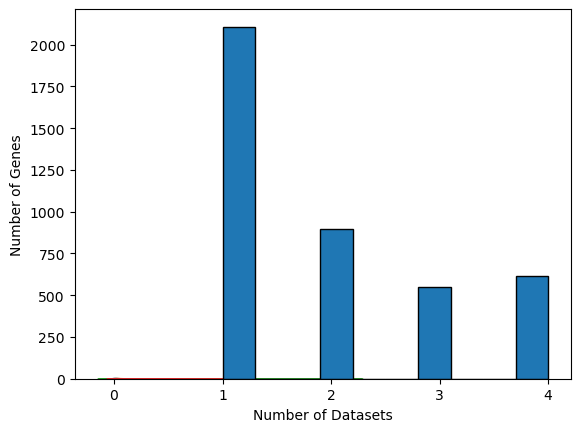

 2000


In [8]:
# load consensus state markers: 
data = pd.read_csv("../../data/consensus_markers.csv")

# merge hvg and take hvg intersects

integrated_data= [Chaffin2022_fibs, 
                    Koenig2022_fibs, 
                    Reichart2022_fibs,
                    Simonson2023_fibs]

# Assuming 'integrated_data' is a list of AnnData objects

# Define the number of highly variable genes you want to select across studys:
num_hvg = 2000
# across samples (per study)
num_hvg_study= 2000

# Create an empty list to store highly variable genes
hvg_list = []

#select top N cell type markers for exclusion
background_genes= select_cmarkers(cmarkers, 0, "Fib")

# Loop through each AnnData object in 'integrated_data'
for x in integrated_data:
    # print(x)
    # after running this without the regresing step we found a cluster that was not interpretable as it clusterd
    # low count cells. 
    x = x[~x.obs_names.isin(poorQ_cells)]
    print(x)

    # Find the variable features using 'vst' selection method, use this only if not calculated earlier
    #x.var['highly_variable'] = True
    #  sc.pp.highly_variable_genes(x, flavor='seurat_vst', n_top_genes=num_hvg)

    # in case hvg are already calculated, calculate the overlap of hvg between samples
    x.var["hvg_prop"]= x.var["highly_variable_nbatches"] / len(x.obs.sample_id.unique())
    
    sns.kdeplot( x.var["hvg_prop"], fill=True)

    # Add labels and a title
    plt.xlabel("proportion of samples with hvg")
    plt.ylabel('Density')
    
    # extract genes and sort by the prorportion of samples reporting
    sorted_df = x.var.sort_values(by="hvg_prop", ascending=False)
    
    # filter this list by background genes
    print(f"number of background genes = {len(background_genes)} ")
    filtered_df = sorted_df[~sorted_df.index.isin(background_genes)]
    print(f"before filtering:  {len(sorted_df)}, after filtering: {len(filtered_df)} ")
    
    sorted_df= filtered_df

    top_n_values = sorted_df.head(num_hvg_study)
    min_value = sorted_df.head(num_hvg_study)["hvg_prop"].min()
    
    print(f"at least {min_value} of samples reported {num_hvg_study}hvg genes")

    # Append variable features to 'hvg_list'
    #hvg_list.extend(x.var_names[x.var['highly_variable_intersection']])
    hvg_list.extend(top_n_values.index)

# Count the frequency of each gene in 'hvg_list' and sort in decreasing order
gene_counts = pd.Series(hvg_list).value_counts().sort_values(ascending=False)

# Create a DataFrame and group by gene count
gene_selection_plt = pd.DataFrame({'gene': gene_counts.index, 'ngenes': gene_counts.values})
gene_selection_plt = gene_selection_plt.groupby('gene').sum().reset_index()

# Create a bar plot using matplotlib
plt.hist(gene_selection_plt.ngenes, bins=10, edgecolor='black') 
plt.xlabel('Number of Datasets')
plt.ylabel('Number of Genes')
plt.show()

#make sure that no gene is selected that was reported by only one study
gene_selection_plt[gene_selection_plt["ngenes"]>1]
# Select the top 'num_hvg' genes
gene_selection = gene_counts.index[:num_hvg]

del integrated_data
print(f" {len(gene_selection)}")
#print(f"{andata.var_names.isin(gene_selection).sum()} of {len(gene_selection)} genes are in concatenated anndata")

In [9]:
## Merge data: 
andata= ad.concat([Chaffin2022_fibs, Koenig2022_fibs, Reichart2022_fibs, Simonson2023_fibs])


In [10]:

# Create a pandas DataFrame with the 'obs_names' column
obs_df = pd.DataFrame(andata.obs_names, columns=['obs_names'])

# Count and print duplicates
duplicate_obs = obs_df[obs_df.duplicated(keep=False)]
print("Duplicate obs_names:")
print(duplicate_obs)

# Count the number of duplicates
num_duplicates = len(duplicate_obs)
print(f"Number of duplicates: {num_duplicates}")


andata.obs_names_make_unique()

# Create a pandas DataFrame with the 'obs_names' column
obs_df = pd.DataFrame(andata.obs_names, columns=['obs_names'])

# Count and print duplicates
duplicate_obs = obs_df[obs_df.duplicated(keep=False)]
print("Duplicate obs_names:")
print(duplicate_obs)

# Count the number of duplicates
num_duplicates = len(duplicate_obs)
print(f"Number of duplicates: {num_duplicates}")

Duplicate obs_names:
                    obs_names
4898     AGAACCTTCCCTGGTT-1-2
8545     AGTAGCTTCGCTATTT-1-3
11926    TAACCAGAGCGTGTCC-1-6
12407    AAACGCTTCGCAGTGC-1-7
18412   ATTGGGTCATGAGAAT-1-11
19125   CATGAGTAGTTAGAAC-1-11
19410   CCCTAACAGGATGAGA-1-11
19525   GATGAGGGTCTACAGT-1-11
19762   AATAGAGAGTAAACGT-1-11
20056   GGGTGAAGTGGAACAC-1-11
24760   GTGCAGCGTCTACTGA-1-13
223669   AGAACCTTCCCTGGTT-1-2
223979   AGTAGCTTCGCTATTT-1-3
229544   TAACCAGAGCGTGTCC-1-6
230730   AAACGCTTCGCAGTGC-1-7
237223  ATTGGGTCATGAGAAT-1-11
237509  AATAGAGAGTAAACGT-1-11
238524  GATGAGGGTCTACAGT-1-11
238526  CATGAGTAGTTAGAAC-1-11
238533  GGGTGAAGTGGAACAC-1-11
238682  CCCTAACAGGATGAGA-1-11
240578  GTGCAGCGTCTACTGA-1-13
Number of duplicates: 22
Duplicate obs_names:
Empty DataFrame
Columns: [obs_names]
Index: []
Number of duplicates: 0


In [11]:
## here we add the step of regressing out the number of counts per cell
print(f"{andata.var_names.isin(gene_selection).sum()} of {len(gene_selection)} genes are in concatenated anndata")

gene_selection2= andata.var_names[andata.var_names.isin(gene_selection)]

gene_selection2.to_frame().to_csv('../../output/fib_sub_analysis/gene_selection_fib_integration.csv', index=False)

subset_adata = andata[:, gene_selection2]



1629 of 2000 genes are in concatenated anndata


In [12]:
subset_adata_obs_names = subset_adata.obs_names.tolist()
poorQ_cells_in_subset = [cell for cell in poorQ_cells if cell in subset_adata_obs_names]

if len(poorQ_cells_in_subset) > 0:
    print("subset_adata contains cells from poorQ_cells")
else:
    print("subset_adata does not contain cells from poorQ_cells")

subset_adata contains cells from poorQ_cells


In [13]:
## regress out the number of counts per cell and scale the data
## this step was added after defining a cell state with high number of cells with low counts that stil passed QC control 
sc.pp.regress_out(subset_adata, keys=['total_counts'])
sc.pp.scale(subset_adata, max_value=10)

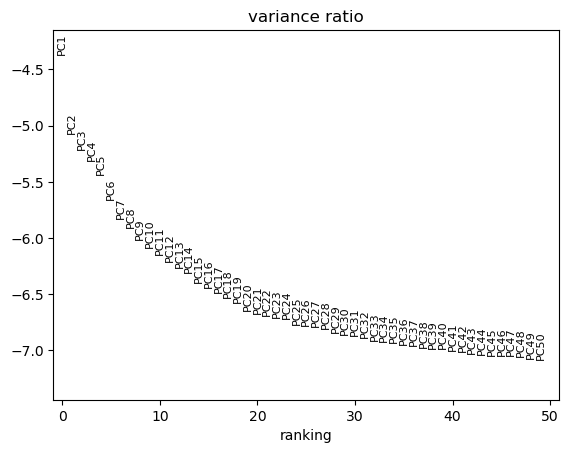

In [14]:
## run PCA 
sc.tl.pca(subset_adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(subset_adata, log=True, n_pcs=50, save='')


In [15]:

sce.pp.harmony_integrate(subset_adata, ['batch', "sample_id"], theta =1)

2024-08-08 14:46:54,011 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-08-08 14:48:38,623 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-08-08 14:48:40,242 - harmonypy - INFO - Iteration 1 of 10
2024-08-08 14:53:41,101 - harmonypy - INFO - Iteration 2 of 10
2024-08-08 14:59:21,334 - harmonypy - INFO - Iteration 3 of 10
2024-08-08 15:04:36,023 - harmonypy - INFO - Converged after 3 iterations


In [16]:
# save the origianl pca space and copy the embedding into the original data object
# help(sce.pp.harmony_integrate)

# save the original pca
andata.obsm["X_pca"]= subset_adata.obsm["X_pca"]
andata.obsm["X_pca_harmony"]= subset_adata.obsm["X_pca_harmony"]

In [17]:
# now we have the batch corrected embedding together with the original counts
andata.layers["counts"]

<242045x14748 sparse matrix of type '<class 'numpy.float64'>'
	with 245432697 stored elements in Compressed Sparse Row format>

In [18]:
#calculate neightorhood graph on coorrected PCA and umap
sc.pp.neighbors(andata, n_neighbors=15, n_pcs=30, use_rep="X_pca_harmony")
sc.tl.umap(andata, min_dist=1.5, spread=2.0, random_state=42)
#sc.tl.leiden(andata, resolution=0.8)

2024-08-08 15:04:38.691667: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-08 15:04:38.915404: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-08 15:04:38.915485: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-08 15:04:38.916610: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-08 15:04:39.028490: I tensorflow/core/platform/cpu_feature_g

In [19]:
andata.write('/home/jan/R-projects/reheat2_pilot/data/celltype_data/Fibs/fibs_integrated_sub_reg_filt.h5ad' )